In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [56.8 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS9_K265_DinhVietHa//LDS9_K265_DinhVietHa_Cuoi_ky/'

/content/gdrive/My Drive/LDS9_K265_DinhVietHa/LDS9_K265_DinhVietHa_Cuoi_ky


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [ ]:
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .appName("CCPP") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "10g") \
  .config("spark.driver.memory", "10g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","10g")\
  .getOrCreate()
spark

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

#### predict the net hourly electrical energy output (EP) of the plant based on Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V)

In [ ]:
data = pd.read_excel("./Du lieu cung cap/CCPP/Folds5x2_pp.xlsx", header=0)

In [ ]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [ ]:
df = spark.createDataFrame(data)

In [ ]:
df.show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
+-----+-----+-------+-----+------+
only showing top 5 rows



In [ ]:
df.count()

9568

In [ ]:
df.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)



#### Exploring variables

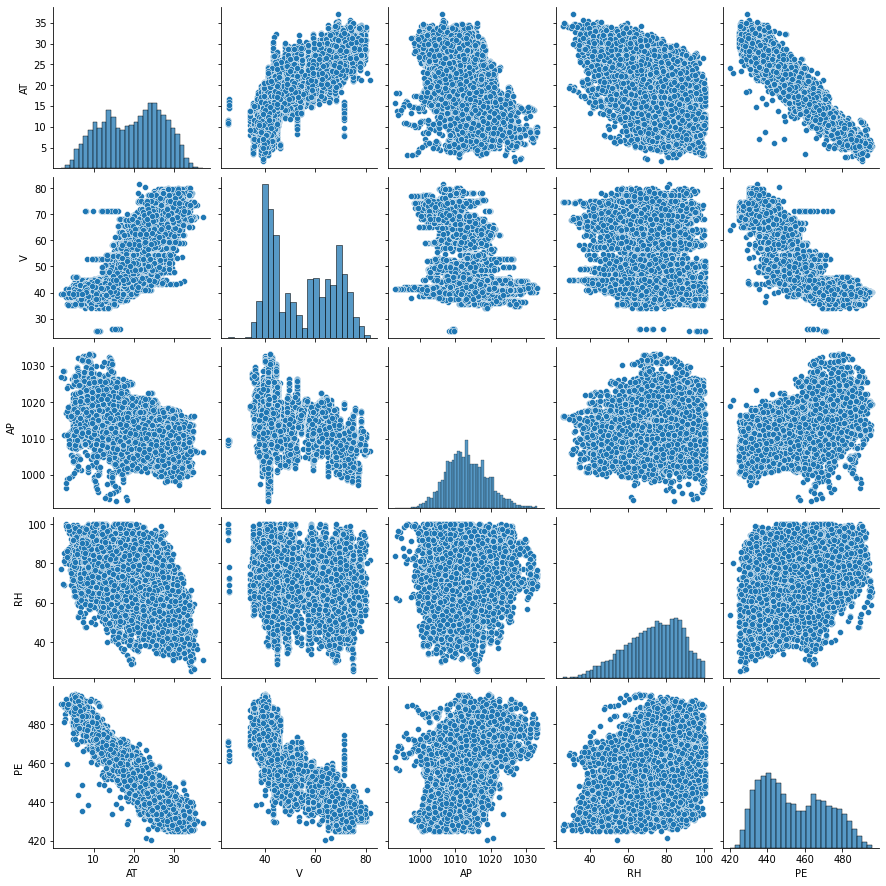

In [ ]:
sns.pairplot(data=data)
plt.show()

From the graph above, we can see that:
* PE (EP) is linearly related to AT and V in negative direction.
* AP and RH seem to be positive related to PE

In [ ]:
for var in df.columns:
  print("PE correlation with " + str(var))
  print(df.corr(var,"PE"))
  print("\n")

PE correlation with AT
-0.94812847041676


PE correlation with V
-0.869780309657789


PE correlation with AP
0.5184290273615734


PE correlation with RH
0.3897940997901022


PE correlation with PE
1.0




In [ ]:
df.describe().show()

+-------+------------------+------------------+-----------------+------------------+-----------------+
|summary|                AT|                 V|               AP|                RH|               PE|
+-------+------------------+------------------+-----------------+------------------+-----------------+
|  count|              9568|              9568|             9568|              9568|             9568|
|   mean|19.651231187290986|54.305803720735874|1013.259078177257| 73.30897784280944|454.3650094063556|
| stddev| 7.452473229611079|12.707892998326805|5.938783705811603|14.600268756728946|17.06699499980342|
|    min|              1.81|             25.36|           992.89|             25.56|           420.26|
|    max|             37.11|             81.56|           1033.3|            100.16|           495.76|
+-------+------------------+------------------+-----------------+------------------+-----------------+



In [ ]:
df.columns

['AT', 'V', 'AP', 'RH', 'PE']

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import isnan, when, count

In [ ]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().T

,0
AT,0
V,0
AP,0
RH,0
PE,0


There is no NaN data.

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
AT,0
V,0
AP,0
RH,0
PE,0


There is no null data.

# Feature transformation

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
df_select = df.select('AT', 'V', 'AP', 'RH','PE')

In [ ]:
assembler =  VectorAssembler(inputCols=['AT', 'V', 'AP', 'RH'],
                             outputCol="features")

In [ ]:
data_pre = assembler.transform(df_select)

In [ ]:
data_pre.show(5)

+-----+-----+-------+-----+------+--------------------+
|   AT|    V|     AP|   RH|    PE|            features|
+-----+-----+-------+-----+------+--------------------+
|14.96|41.76|1024.07|73.17|463.26|[14.96,41.76,1024...|
|25.18|62.96|1020.04|59.08|444.37|[25.18,62.96,1020...|
| 5.11| 39.4|1012.16|92.14|488.56|[5.11,39.4,1012.1...|
|20.86|57.32|1010.24|76.64|446.48|[20.86,57.32,1010...|
|10.82| 37.5|1009.23|96.62| 473.9|[10.82,37.5,1009....|
+-----+-----+-------+-----+------+--------------------+
only showing top 5 rows



In [ ]:
final_data = data_pre.select("features","PE") 

In [ ]:
training, testing = final_data.randomSplit([0.8,0.2])

In [ ]:
training.describe().show()

+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              7675|
|   mean| 454.3514631921825|
| stddev|17.020785700196992|
|    min|            420.26|
|    max|            495.76|
+-------+------------------+



In [ ]:
testing.describe().show()

+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              1893|
|   mean|454.41993132593774|
| stddev|17.257504169312696|
|    min|            421.57|
|    max|            494.84|
+-------+------------------+



The train and test set are not much different in statistical properties.

# Linear regression model

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
lr = LinearRegression(featuresCol="features", 
                      labelCol="PE",
                      predictionCol='predict_PE')

In [ ]:
lr_model = lr.fit(training,)

In [ ]:
print("Coefficients: {} Intercept: {}".format(lr_model.coefficients, lr_model.intercept))

Coefficients: [-1.9682822619867588,-0.23512562911534574,0.06870221855373973,-0.15814197702758442] Intercept: 447.7621341615309


In [ ]:
test_results = lr_model.evaluate(testing)

In [ ]:
test_results.residuals.show(5)

+------------------+
|         residuals|
+------------------+
|-4.121352356278578|
|2.2606116863727834|
|  4.34571345753551|
|4.2538377122428415|
|1.4503199520827934|
+------------------+
only showing top 5 rows



Checking test set and inspecting the results

In [ ]:
test_model = lr_model.transform(testing)

In [ ]:
test_model.select("predict_PE","PE").show(5)

+------------------+------+
|        predict_PE|    PE|
+------------------+------+
|489.32135235627857| 485.2|
|486.71938831362723|488.98|
| 484.4642865424645|488.81|
|488.20616228775714|492.46|
| 488.2296800479172|489.68|
+------------------+------+
only showing top 5 rows



Evaluate the model

In [ ]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))
print("r2: {}".format(test_results.r2))

RMSE: 4.440429742181025
MSE: 19.717416295245847
r2: 0.9337595134519641


The model returns low RMSE and MSE with good R2 score (93%).

-> This linear model is good.

# Try scaling the features and train another linear model

#### StandardScaler

In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
scaler = StandardScaler(inputCol = "features",
                        outputCol = "scaledFeatures",
                        withStd = True,
                        withMean= False)

In [ ]:
scalerModel = scaler.fit(final_data)

In [ ]:
scaled_data = scalerModel.transform(final_data)

In [ ]:
scaled_data.show(truncate=False)

+---------------------------+------+----------------------------------------------------------------------------+
|features                   |PE    |scaledFeatures                                                              |
+---------------------------+------+----------------------------------------------------------------------------+
|[14.96,41.76,1024.07,73.17]|463.26|[2.007387284607625,3.2861466496057496,172.4376658132642,5.011551582999288]  |
|[25.18,62.96,1020.04,59.08]|444.37|[3.378744106044117,4.954401174788745,171.75907568443762,4.046500854497717]  |
|[5.11,39.4,1012.16,92.14]  |488.56|[0.6856784107182462,3.1004352968023596,170.4322046633077,6.3108427341472515]|
|[20.86,57.32,1010.24,76.64]|446.48|[2.7990707725210595,4.510582518089119,170.10890614039278,5.249218440905636] |
|[10.82,37.5,1009.23,96.62] |473.9 |[1.4518670066480281,2.950921919545393,169.93883764656775,6.6176864008390215]|
|[26.27,59.44,1012.23,58.77]|443.67|[3.5250042758450735,4.677407970607417,170.4439915886

In [ ]:
training_1, testing_1 = scaled_data.randomSplit([0.8,0.2])

In [ ]:
lr_1 = LinearRegression(featuresCol="scaledFeatures",
                        labelCol="PE",
                        predictionCol="predict_PE")

In [ ]:
lr_model_1 = lr_1.fit(training_1,)

In [ ]:
print("Coefficients: {} Intercept: {}".format(lr_model_1.coefficients, lr_model_1.intercept))

Coefficients: [-14.65877013054186,-3.069352061090372,0.347700828703893,-2.326969946075896] Intercept: 458.5204215111065


In [ ]:
test_results_1 = lr_model_1.evaluate(testing_1)

In [ ]:
test_results_1.residuals.show(5)

+------------------+
|         residuals|
+------------------+
|-1.816943282244381|
|1.7505763810166854|
|3.2628911504927487|
| 7.634829836120673|
|1.7557336450593652|
+------------------+
only showing top 5 rows



Checking test set and inspecting the results

In [ ]:
test_model_1 = lr_model_1.transform(testing_1)

In [ ]:
test_model_1.select("predict_PE","PE").show(5)

+------------------+------+
|        predict_PE|    PE|
+------------------+------+
| 489.0069432822444|487.19|
| 487.8894236189833|489.64|
|486.17710884950725|489.44|
|486.23517016387933|493.87|
|483.67426635494064|485.43|
+------------------+------+
only showing top 5 rows



Evaluate the model

In [ ]:
print("RMSE: {}".format(test_results_1.rootMeanSquaredError))
print("MSE: {}".format(test_results_1.meanSquaredError))
print("r2: {}".format(test_results_1.r2))

RMSE: 4.549224223228702
MSE: 20.695441033210784
r2: 0.9286884357651137


No difference in accuracy after scaling 

-> Standard Scaling has no definitive meaning in this problem.

#### MinMaxScaler

In [ ]:
from pyspark.ml.feature import MinMaxScaler

In [ ]:
scaler1 = MinMaxScaler(inputCol = "features",
                        outputCol = "scaledFeatures",
                       )

In [ ]:
scalerModel_1 = scaler1.fit(final_data)

In [ ]:
scaled_data_1 = scalerModel_1.transform(final_data)

In [ ]:
scaled_data_1.show(truncate=False)

+---------------------------+------+-------------------------------------------------------------------------------+
|features                   |PE    |scaledFeatures                                                                 |
+---------------------------+------+-------------------------------------------------------------------------------+
|[14.96,41.76,1024.07,73.17]|463.26|[0.37252124645892354,0.29181494661921703,0.7715911902994302,0.6382037533512065]|
|[25.18,62.96,1020.04,59.08]|444.37|[0.6620396600566573,0.6690391459074733,0.6718634001484781,0.4493297587131367]  |
|[5.11,39.4,1012.16,92.14]  |488.56|[0.0934844192634561,0.24982206405693946,0.4768621628309824,0.8924932975871314] |
|[20.86,57.32,1010.24,76.64]|446.48|[0.5396600566572238,0.5686832740213523,0.4293491709972788,0.6847184986595175]  |
|[10.82,37.5,1009.23,96.62] |473.9 |[0.25524079320113313,0.21601423487544483,0.4043553575847574,0.9525469168900805]|
|[26.27,59.44,1012.23,58.77]|443.67|[0.6929178470254959,0.606405

In [ ]:
training_2, testing_2 = scaled_data_1.randomSplit([0.7,0.3])

In [ ]:
lr_2 = LinearRegression(featuresCol="scaledFeatures",
                        labelCol="PE",
                        predictionCol="predict_PE")

In [ ]:
lr_model_2 = lr_2.fit(training_2,)

In [ ]:
print("Coefficients: {} Intercept: {}".format(lr_model_2.coefficients, lr_model_2.intercept))

Coefficients: [-70.43123674223187,-12.688080191577546,2.34105751003272,-12.03377208201579] Intercept: 503.07968342858004


In [ ]:
test_results_2 = lr_model_2.evaluate(testing_2)

In [ ]:
test_results_2.residuals.show(5)

+------------------+
|         residuals|
+------------------+
|-7.010979862176214|
| 4.603614333340829|
| 4.068611258257874|
|0.4251086613560915|
|5.9797567482868885|
+------------------+
only showing top 5 rows



Checking test set and inspecting the results

In [ ]:
test_model_2 = lr_model_2.transform(testing_2)

In [ ]:
test_model_2.select("predict_PE","PE").show(5)

+------------------+------+
|        predict_PE|    PE|
+------------------+------+
|489.67097986217624|482.66|
|484.77638566665917|489.38|
|485.04138874174214|489.11|
| 488.2448913386439|488.67|
|484.93024325171314|490.91|
+------------------+------+
only showing top 5 rows



Evaluate the model

In [ ]:
print("RMSE: {}".format(test_results_2.rootMeanSquaredError))
print("MSE: {}".format(test_results_2.meanSquaredError))
print("r2: {}".format(test_results_2.r2))

RMSE: 4.679099966003332
MSE: 21.893976491852385
r2: 0.9258217959548516


No difference in accuracy after scaling 

-> MinMax Scaling has no definitive meaning in this problem.